# Проект: классификация

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Загрузим данные и познакомимся с ними

In [173]:
bank_df = pd.read_csv('data/bank_fin.csv', sep = ';')
display(bank_df.head())
display(bank_df.info())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

### Описание столбцов датасета

#### Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

#### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

#### Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

#### Целевой признак
* deposit

В некоторых столбцах есть явные пропуски. Давайте посмотрим, в каких именно и сколько.

In [174]:
bank_df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Теперь попробуем найти неявные пропуски, они могут скрываться в столбцах object. Посмотрим на количество уникальных значений для таких столбцов.

In [175]:
bank_df.describe(include='object')

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


Обратим внимание, что у столбца balance тоже тип object. Это объяняется тем, как он оформлен (добавлен знак $, а также пробел и запятая в качестве разделителей). Большое количество уникальных значений объясняется тем, что этот признак должен быть числовым. Пока опустим этот столбец и составим таблицу уникальных значений для других столбцов. 

In [176]:
# составим список столбцов object, исключив столбец balance и таргет deposit
object_columns = [col for col in bank_df.drop(['balance', 'deposit'], axis=1).columns if bank_df.dtypes[col] == object]

# создадим таблицу уникальных значений для полученных столбцов
unique_object_values = pd.DataFrame()
for col in object_columns:
    new_column = pd.DataFrame({col: bank_df[col].unique()})
    unique_object_values = pd.concat([unique_object_values, new_column], axis=1)
unique_object_values[unique_object_values.isna()] = '-'

display(unique_object_values)

,job,marital,education,default,housing,loan,contact,month,poutcome
0,admin.,married,secondary,no,yes,no,unknown,may,unknown
1,technician,single,tertiary,yes,no,yes,cellular,jun,other
2,services,divorced,primary,-,-,-,telephone,jul,failure
3,management,-,unknown,-,-,-,-,aug,success
4,retired,-,-,-,-,-,-,oct,-
5,blue-collar,-,-,-,-,-,-,nov,-
6,unemployed,-,-,-,-,-,-,dec,-
7,entrepreneur,-,-,-,-,-,-,jan,-
8,housemaid,-,-,-,-,-,-,feb,-
9,unknown,-,-,-,-,-,-,mar,-


Мы видим, что значение unknown есть в столбцах job, education, contact и poutcome. Проверим, как много таких значений.

In [177]:
# составим таблицу, в которой для рассматриваемых столбцов укажем процент значений unknown
unknown_columns = ['job', 'education', 'contact', 'poutcome']
unknown_df = pd.DataFrame(columns=['Percent of unknown values'])
for col in unknown_columns:
    unknown_df.loc[col] = bank_df[col].value_counts(normalize=True).loc['unknown']

display(unknown_df)

,Percent of unknown values
job,0.006271
education,0.044526
contact,0.210177
poutcome,0.745924


В столбцах job и education таких значений не много, поэтому мы можем заменить их на значения, которые чаще всего встречаются в этих столбцах, то есть моды.

In [178]:
mask = bank_df['job'] == 'unknown'
job_mode = bank_df['job'].mode()
bank_df.loc[mask, 'job'] = job_mode[0]

mask = bank_df['education'] == 'unknown'
education_mode = bank_df['education'].mode()
bank_df.loc[mask, 'education'] = education_mode[0]

Вернемся к столбцу balance и приведем его к типу float, сохранив значения NaN.

In [179]:
bank_df['balance'] = bank_df['balance'].apply(
    lambda x: x if pd.isna(x) else float(x[:-2].strip().replace(' ','').replace(',','.'))
)

Посмотрим на распределение значений в этом столбце.

In [180]:
bank_df['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

Среднее значение сильно отличается от медианного, поэтому заменим отсутствующие значения на медианное.

In [181]:
balance_median = bank_df['balance'].median()
bank_df.loc[bank_df['balance'].isna(), 'balance'] = balance_median

Теперь по отдельности рассмотрим числовые столбцы на предмет выбросов.

In [182]:
numerical_columns = [col for col in bank_df.drop('deposit', axis=1).columns if col not in object_columns]
print(f'Всего числовых столбцов {len(numerical_columns)}: {(numerical_columns)}')

Всего числовых столбцов 7: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


### Признак age

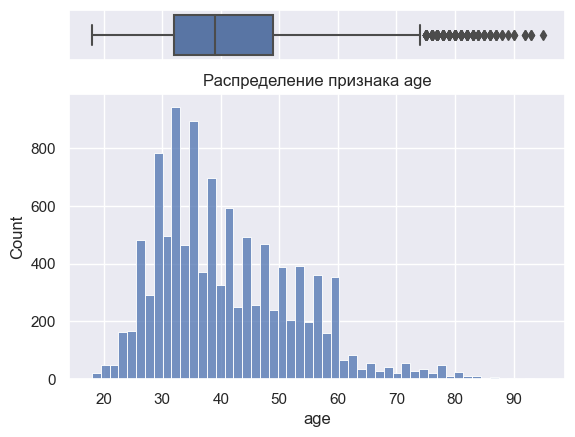

In [183]:
sns.set(style="darkgrid")
 
# создадим объект с двумя координатными плоскостями (ax_box и ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# назначим график для каждой плоскости
sns.boxplot(x = bank_df["age"], ax=ax_box)
sns.histplot(data=bank_df, x="age", ax=ax_hist)
 
# удалим название оси x для boxplot и добавим название графика
ax_box.set(xlabel='')
plt.title('Распределение признака age')
plt.show()

Явных выбросов по возрасту нет.

### Признак balance

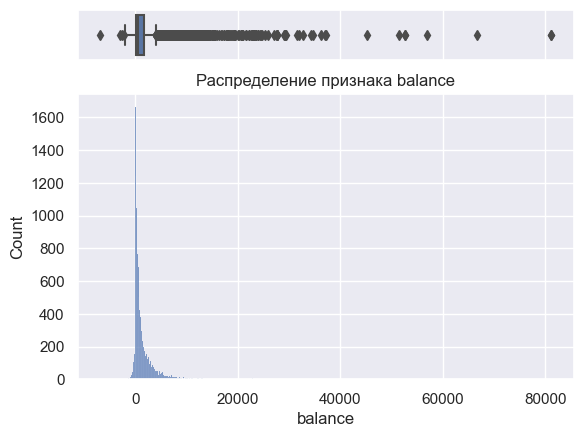

In [184]:
sns.set(style="darkgrid")
 
# создадим объект с двумя координатными плоскостями (ax_box и ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# назначим график для каждой плоскости
sns.boxplot(x = bank_df["balance"], ax=ax_box)
sns.histplot(data=bank_df, x="balance", ax=ax_hist)
 
# удалим название оси x для boxplot и добавим название графика
ax_box.set(xlabel='')
plt.title('Распределение признака balance')
plt.show()

К явному выбросу здесь можно отнести точку левее -5000 и точки правее 40 000. Удалим соответствующие записи из набора данных.

In [185]:
bank_df = bank_df[(bank_df['balance'] > -5000) & (bank_df['balance'] < 40_000)]

### Признак day

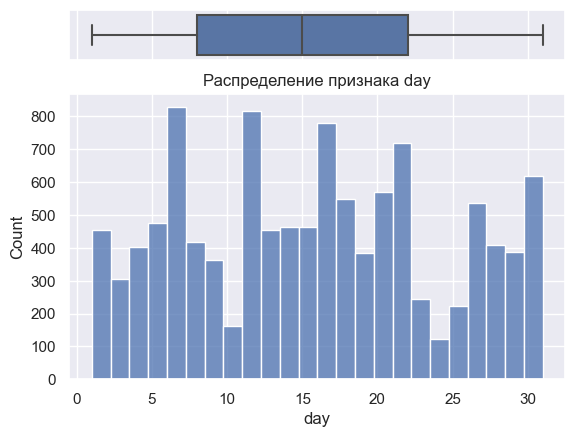

In [186]:
sns.set(style="darkgrid")
 
# создадим объект с двумя координатными плоскостями (ax_box и ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# назначим график для каждой плоскости
sns.boxplot(x = bank_df["day"], ax=ax_box)
sns.histplot(data=bank_df, x="day", ax=ax_hist)
 
# удалим название оси x для boxplot и добавим название графика
ax_box.set(xlabel='')
plt.title('Распределение признака day')
plt.show()

Явных выбросов по признаку day нет. Кроме того, этот признак можно отнести к категориальным.

### Признак duration

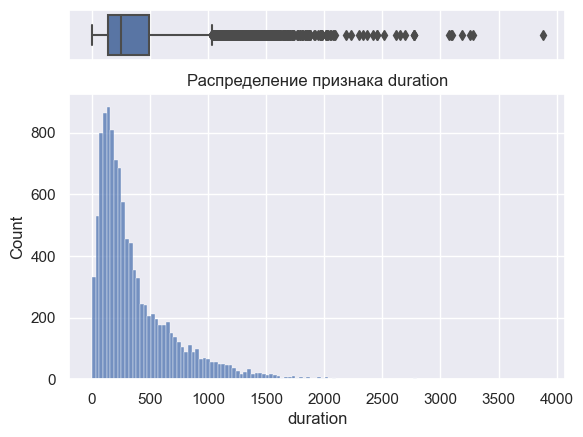

In [187]:
sns.set(style="darkgrid")
 
# создадим объект с двумя координатными плоскостями (ax_box и ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# назначим график для каждой плоскости
sns.boxplot(x = bank_df["duration"], ax=ax_box)
sns.histplot(data=bank_df, x="duration", ax=ax_hist)
 
# удалим название оси x для boxplot и добавим название графика
ax_box.set(xlabel='')
plt.title('Распределение признака duration')
plt.show()

К выбросам здесь можно отнести наблюдения, для которых признак duration больше 3000. Удалим соответствующие записи из набора данных.

In [188]:
bank_df = bank_df[bank_df["duration"] < 3000]

### Признак campaign

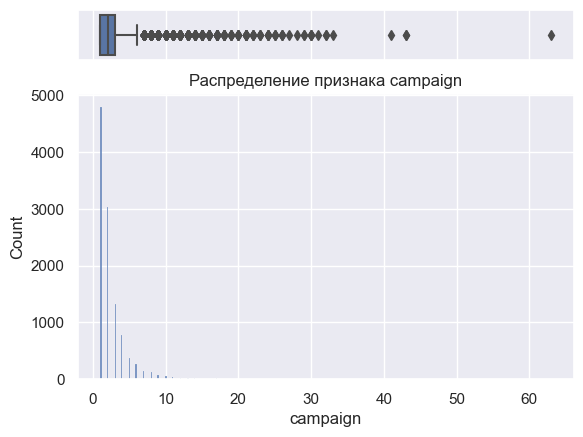

In [189]:
sns.set(style="darkgrid")
 
# создадим объект с двумя координатными плоскостями (ax_box и ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# назначим график для каждой плоскости
sns.boxplot(x = bank_df["campaign"], ax=ax_box)
sns.histplot(data=bank_df, x="campaign", ax=ax_hist)
 
# удалим название оси x для boxplot и добавим название графика
ax_box.set(xlabel='')
plt.title('Распределение признака campaign')
plt.show()

К выбросам здесь можно отнести наблюдения со значением больше 40. Признак campaing также можно отнести к категориальным.

In [190]:
bank_df = bank_df[bank_df["campaign"] < 40]

### Признак pdays

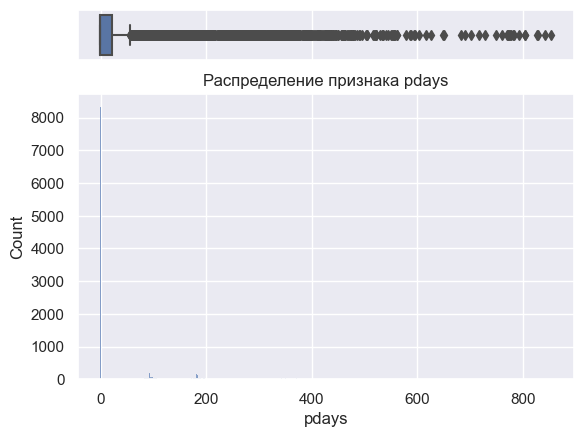

In [191]:
sns.set(style="darkgrid")
 
# создадим объект с двумя координатными плоскостями (ax_box и ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# назначим график для каждой плоскости
sns.boxplot(x = bank_df["pdays"], ax=ax_box)
sns.histplot(data=bank_df, x="pdays", ax=ax_hist)
 
# удалим название оси x для boxplot и добавим название графика
ax_box.set(xlabel='')
plt.title('Распределение признака pdays')
plt.show()

Явных выбросов по признаку pdays нет.

### Признак previous

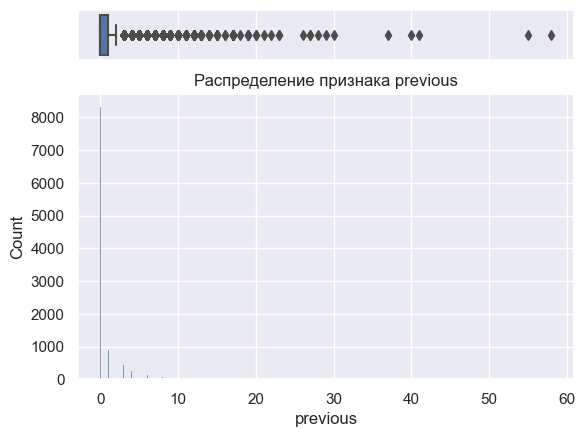

In [192]:
sns.set(style="darkgrid")
 
# создадим объект с двумя координатными плоскостями (ax_box и ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# назначим график для каждой плоскости
sns.boxplot(x = bank_df["previous"], ax=ax_box)
sns.histplot(data=bank_df, x="previous", ax=ax_hist)
 
# удалим название оси x для boxplot и добавим название графика
ax_box.set(xlabel='')
plt.title('Распределение признака previous')
plt.show()

К выбросам здесь можно отнести наблюдения со значением больше 30. Признак previous также можно отнести к категориальным.

In [193]:
bank_df = bank_df[bank_df["previous"] <= 30]

## Часть 2:  Разведывательный анализ

### Посмотрим, сбалансирован ли набор данных по целевому признаку

Распределение значений целевого признака в процентах:


no     52.626381
yes    47.373619
Name: deposit, dtype: float64

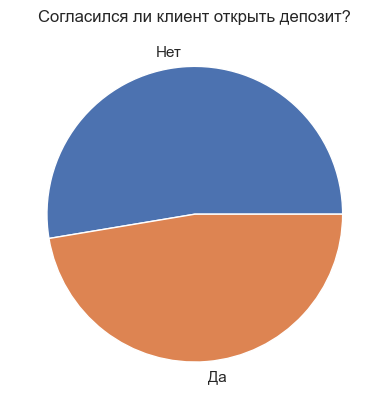

In [194]:
print('Распределение значений целевого признака в процентах:')
display(bank_df['deposit'].value_counts(normalize=True) * 100)
plt.pie(bank_df['deposit'].value_counts(), labels=['Нет', 'Да'])
plt.title('Согласился ли клиент открыть депозит?')
plt.show()

### Рассмотрим признаки, разбив наблюдения на классы по целевой переменной. Начнем с числовых признаков.

,age,balance,day,duration,campaign,pdays,previous
count,11137.000000,11137.000000,11137.000000,11137.000000,11137.000000,11137.000000,11137.000000
mean,41.219538,1485.387357,15.659693,370.231211,2.493311,51.189638,0.813145
std,11.902880,2783.493155,8.421407,339.464248,2.581950,108.330471,2.075102
min,18.000000,-3058.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,123.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1697.000000,22.000000,495.000000,3.000000,17.000000,1.000000
max,95.000000,37127.000000,31.000000,2775.000000,33.000000,854.000000,30.000000


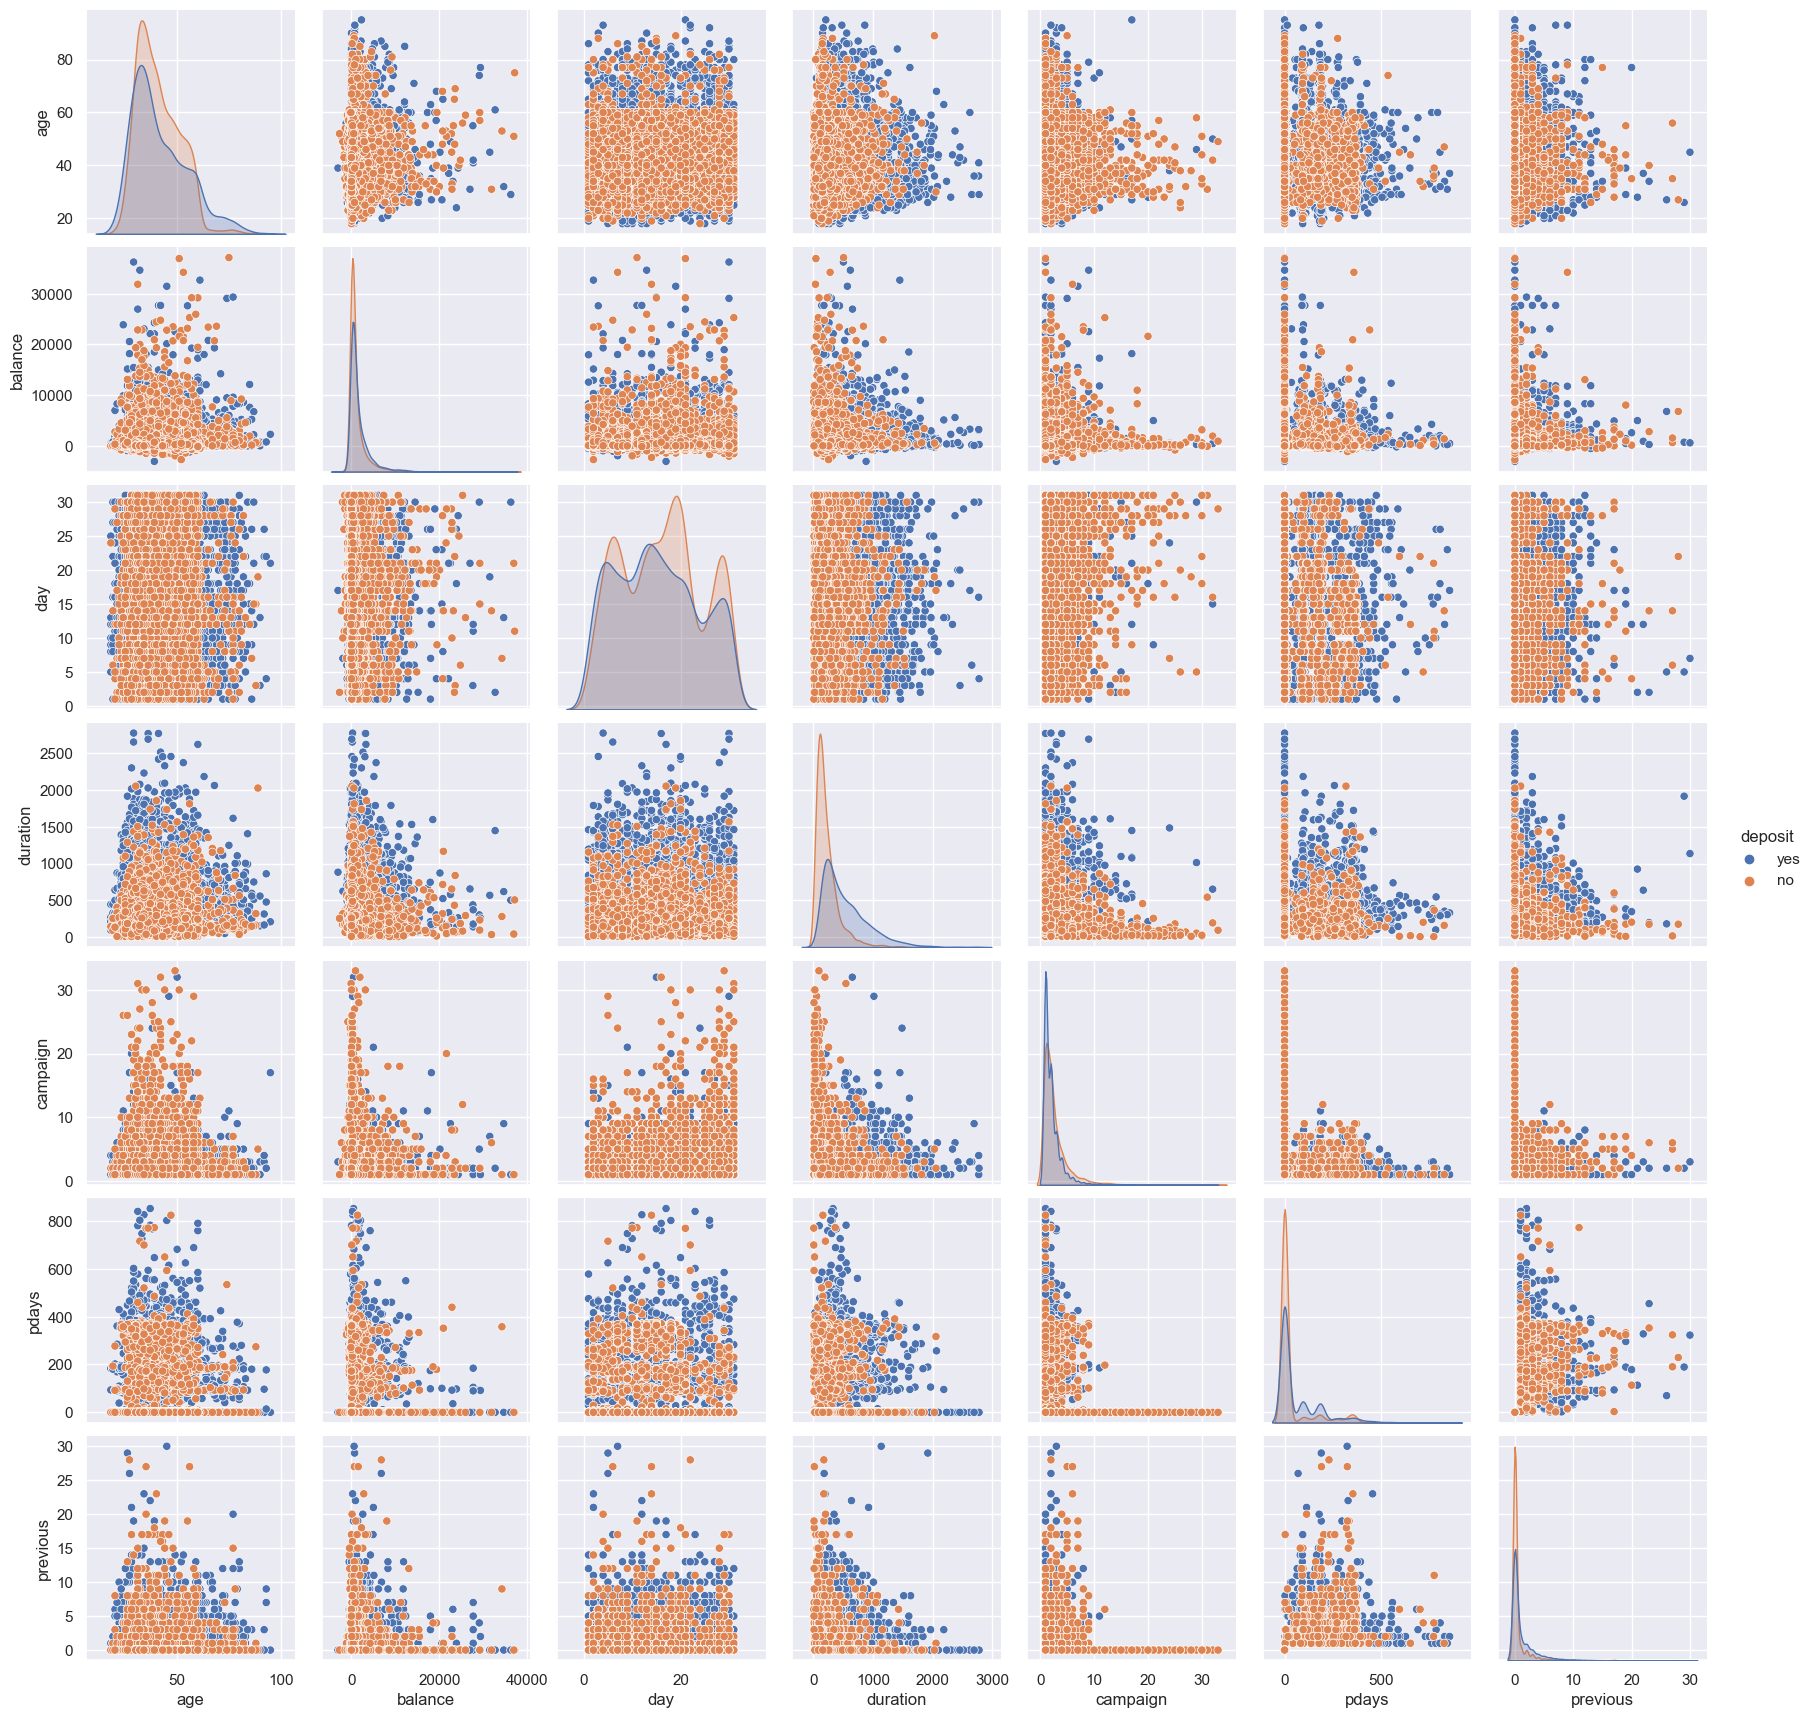

In [195]:
display(bank_df.describe())

sns.pairplot(bank_df, hue='deposit')
plt.show()

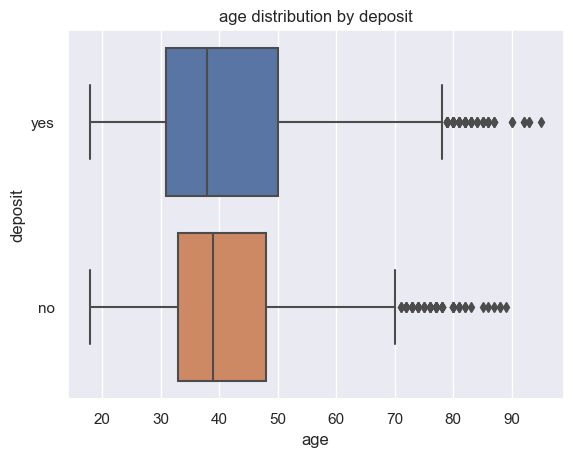

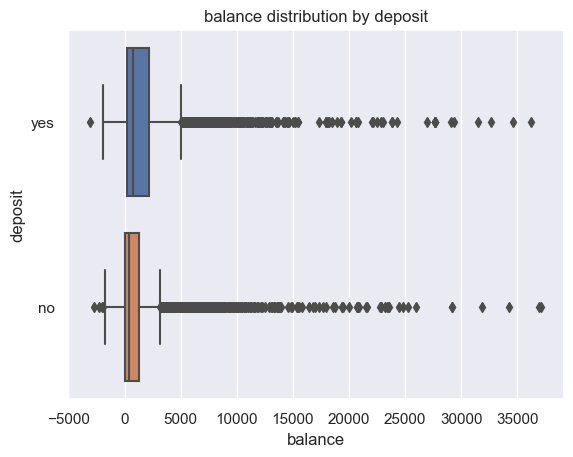

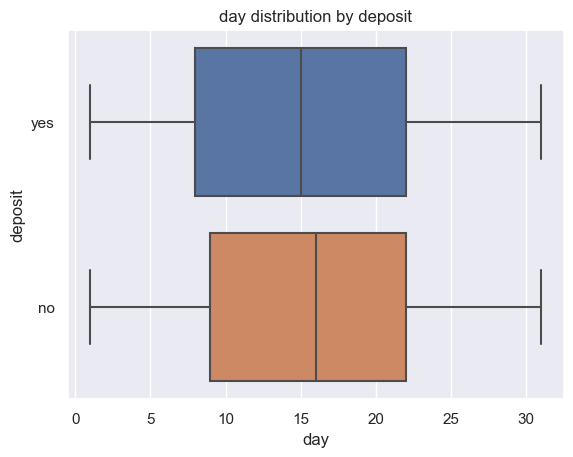

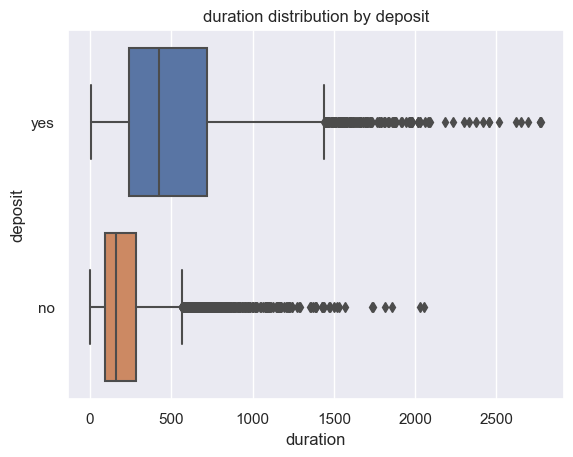

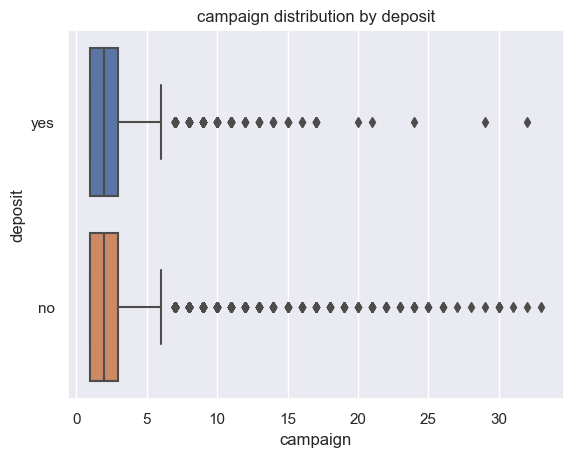

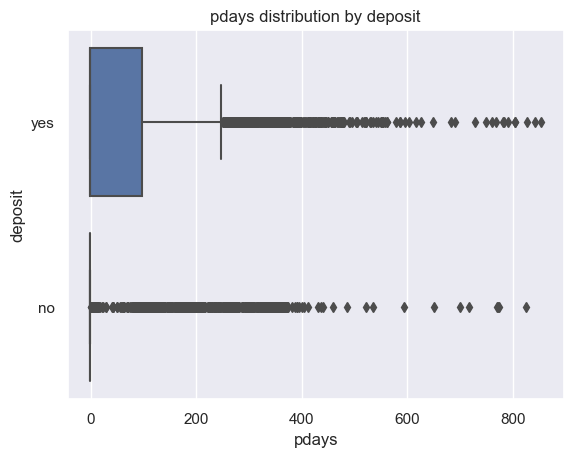

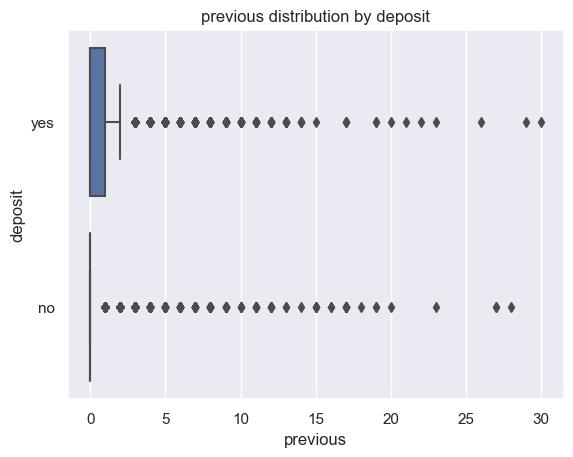

In [196]:
# создадим список числовых признаков
numerical_columns = [col for col in bank_df.drop('deposit', axis=1).columns if col not in object_columns]

for col in numerical_columns:
    sns.boxplot(data=bank_df, x=col, y='deposit')
    plt.title(f'{col} distribution by deposit')
    plt.show()

Наибольшие расхождения между классами наблюдаются для признаков duration, pdays и previous.

### Теперь рассмотрим категорияльные признаки для наших классов

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,11137,11137,11137,11137,11137,11137,11137,11137,11137,11137
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2633,6335,5956,10970,5869,9686,8031,2818,8309,5861


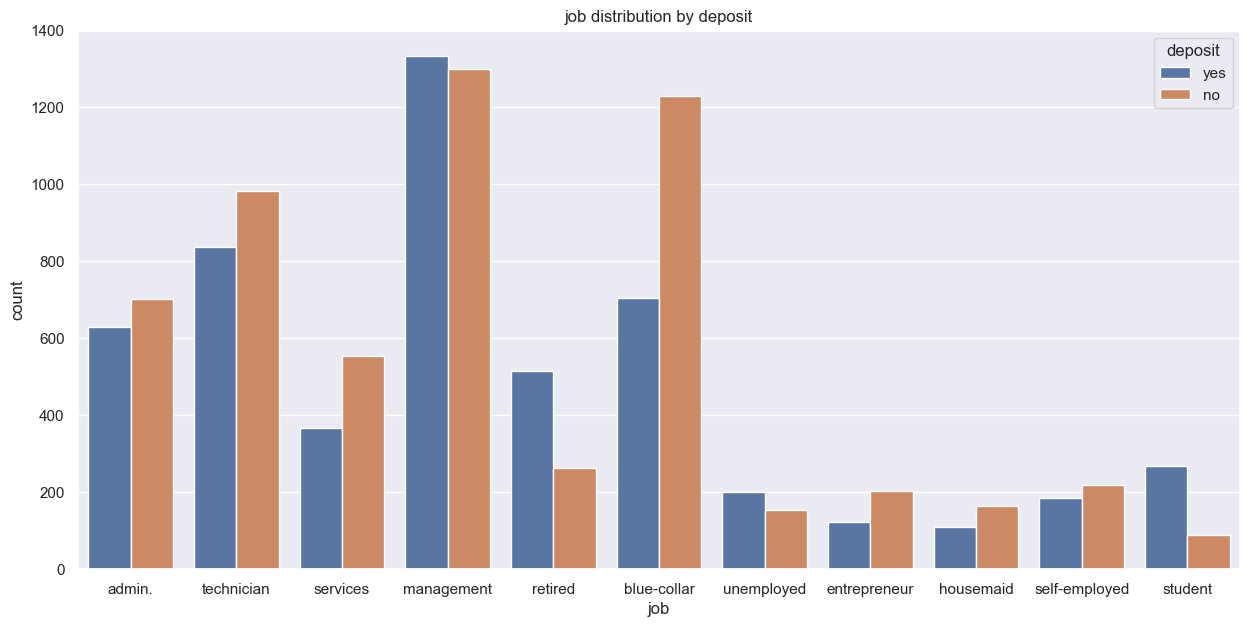

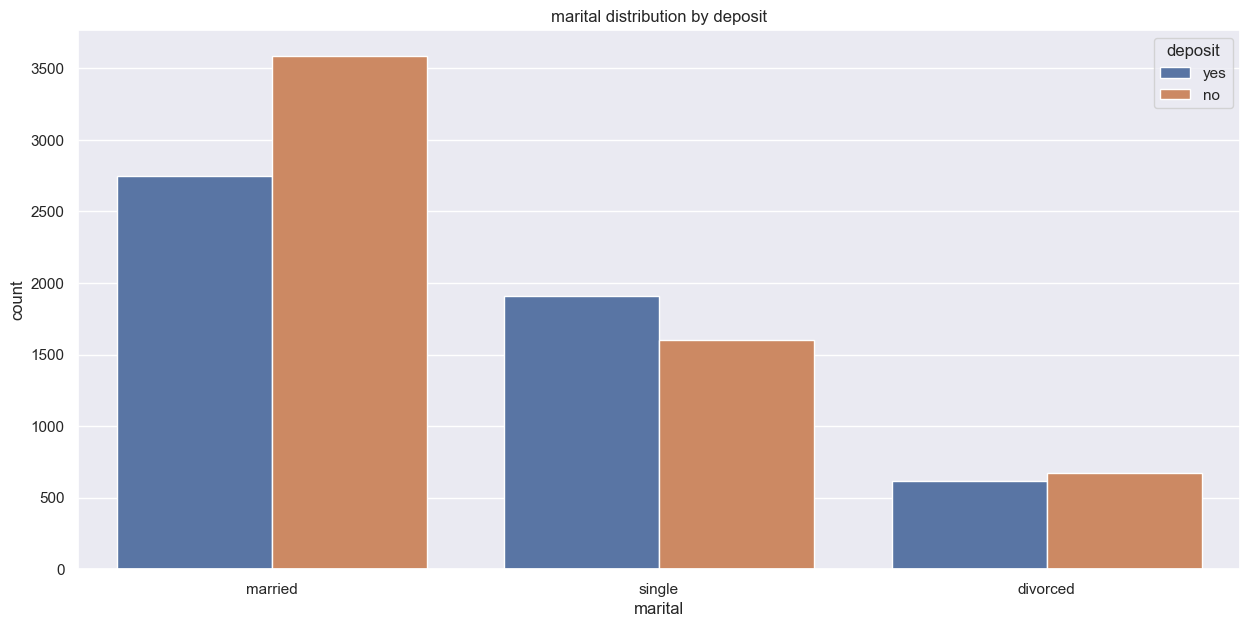

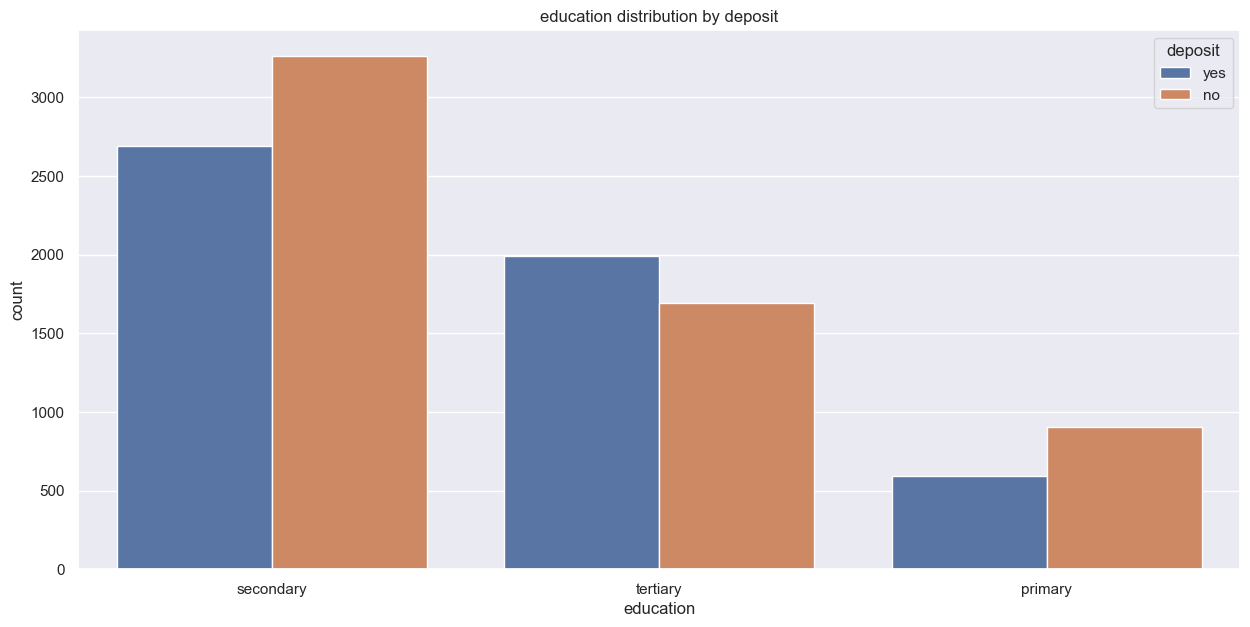

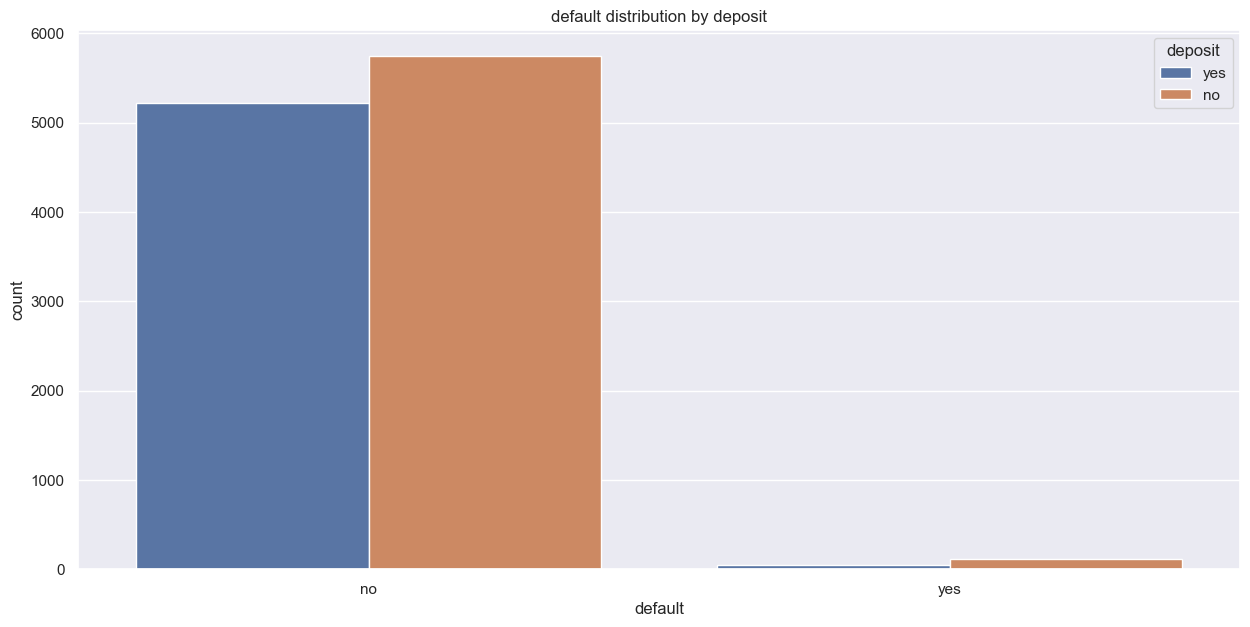

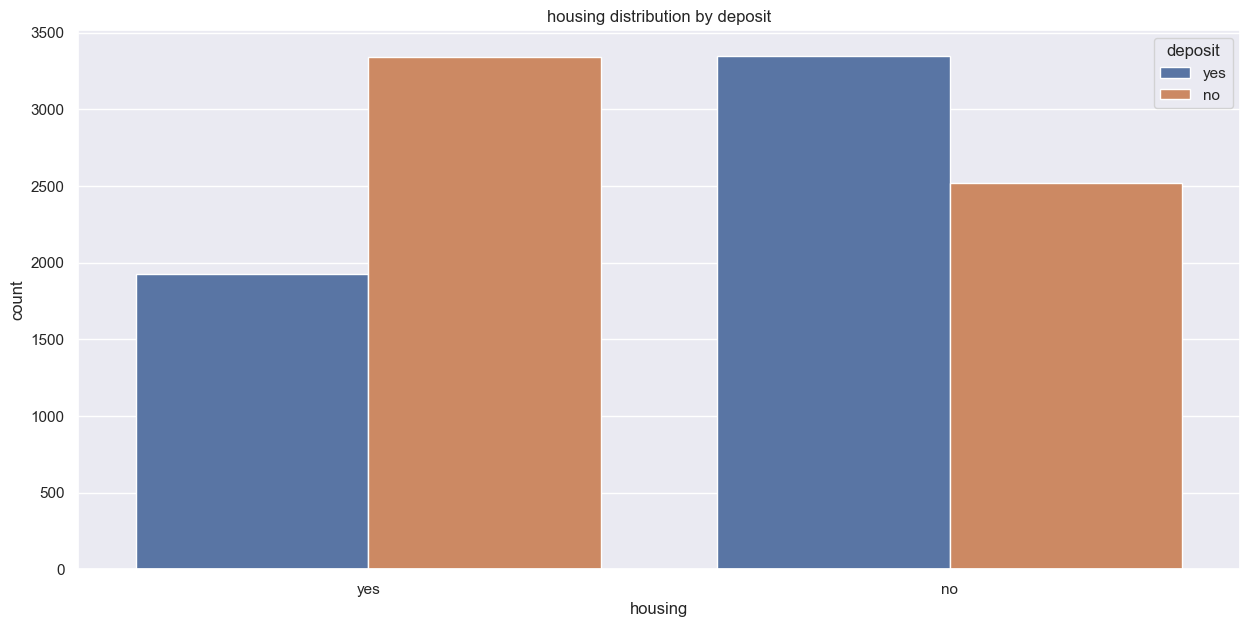

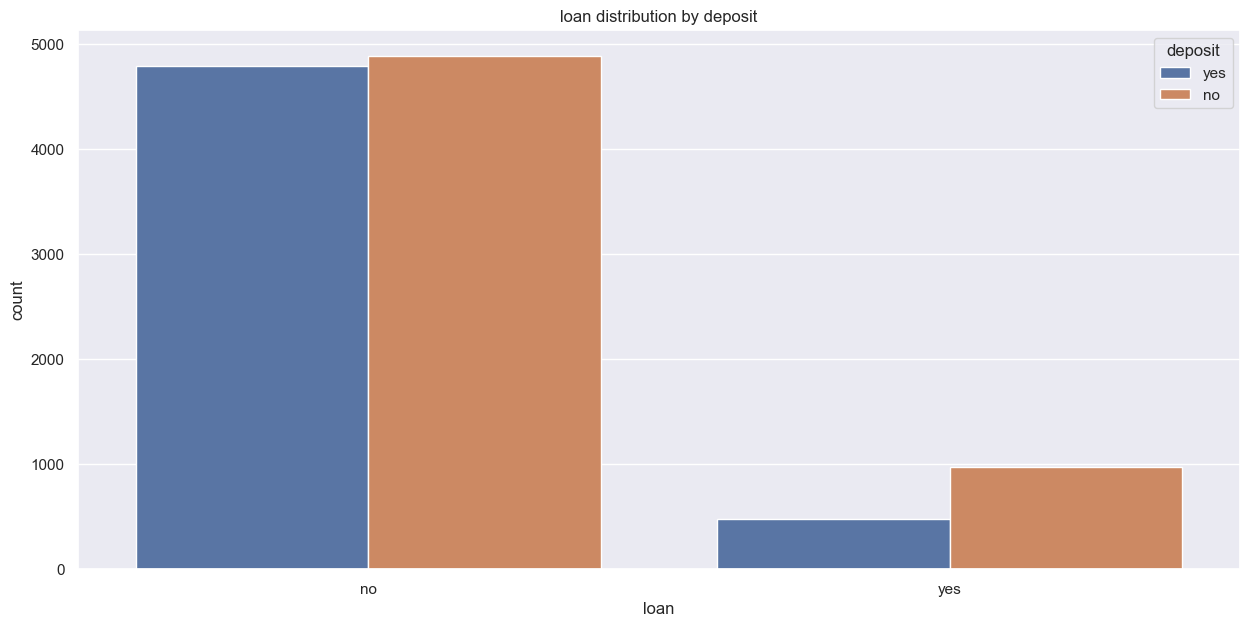

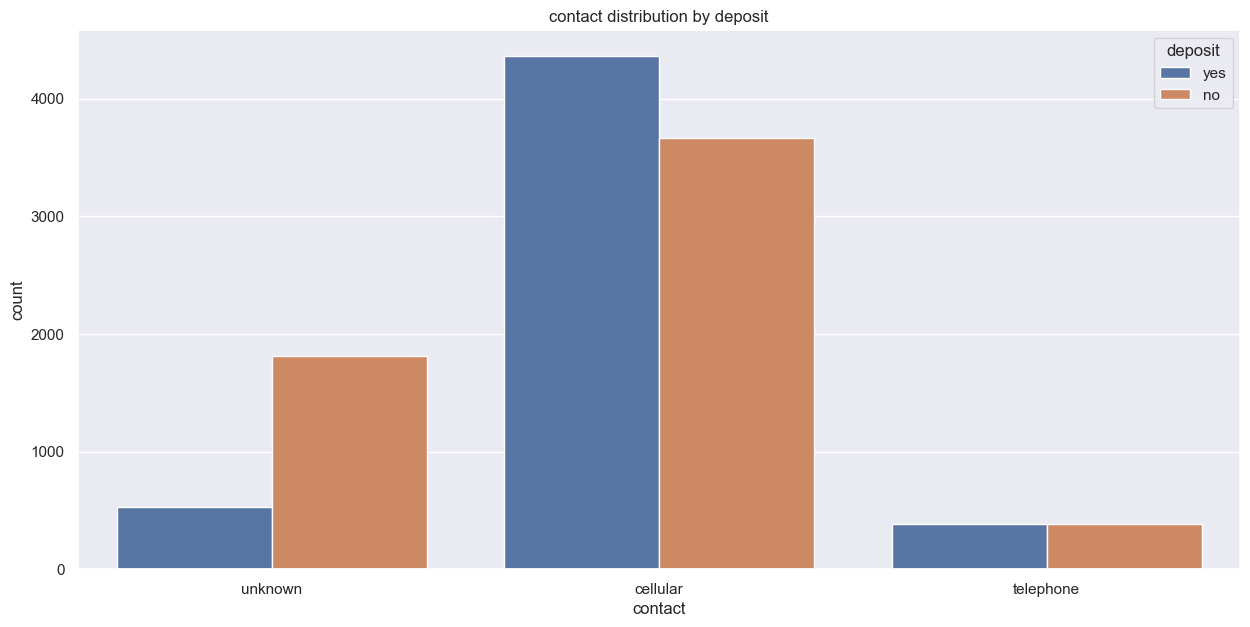

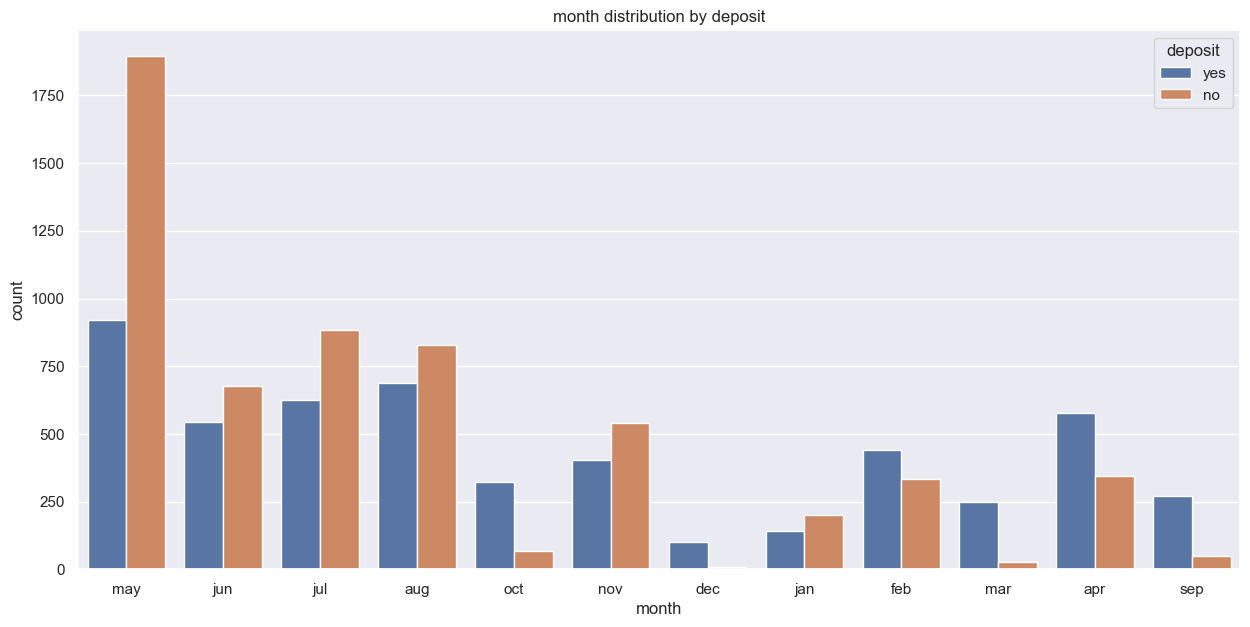

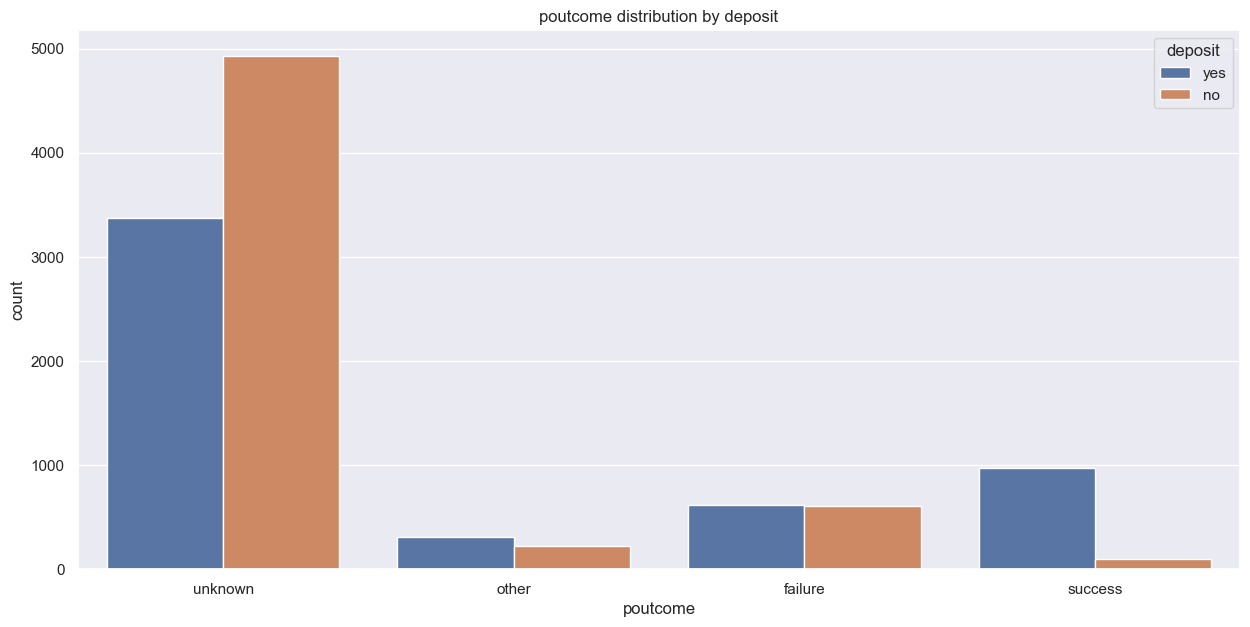

In [197]:
display(bank_df.describe(include='object'))

for col in object_columns:
    plt.figure(figsize=(15, 7))
    sns.countplot(x=bank_df[col], hue=bank_df['deposit'])
    plt.title(f'{col} distribution by deposit')
    plt.show()

Можно заменить, что чаще открывают депозиты неженатые люди, специалисты на руководящих должностях, лица без кредита на жилье, а также те, кого успешно привлекли с помощью маркетинговой компании. Кроме того, бросается в глаза сезонность открытия депозитов.

## Часть 3: преобразование данных

### Разобьем признак age на категории

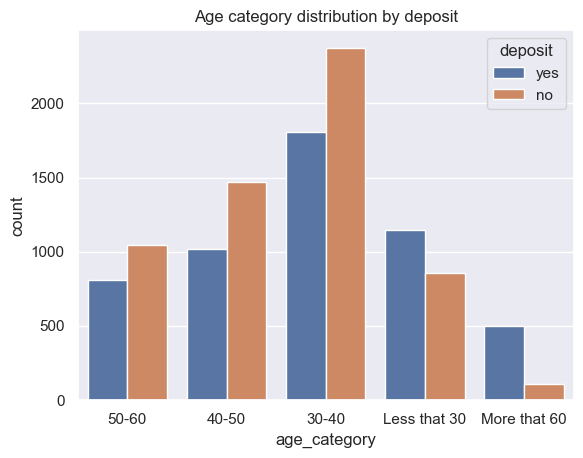

In [198]:
# создадим словарь для удобной интерпретации
age_category_dict = dict({
    0 : 'Less that 30',
    1 : '30-40',
    2 : '40-50',
    3 : '50-60',
    4 : 'More that 60',
})

# создадим функцию для преобразования признака
def age_category_funk(number):
    if number <= 30: return 0
    elif number <= 40: return 1
    elif number <= 50: return 2
    elif number <= 60: return 3
    else: return 4

# преобразуем признак
bank_df['age_category'] = bank_df['age'].apply(age_category_funk)

# создадим список столбцов, которые нужно будет удалить после преобразования
# и дообавим в него признак age
drop_cols = list()
drop_cols.append('age')

# изобразим признак с новыми значениями
sns.countplot(x=bank_df['age_category'].apply(lambda x: age_category_dict[x]), hue=bank_df['deposit'])
plt.title('Age category distribution by deposit')
plt.show()

### Аналогично разобьем признак previous на категории. 

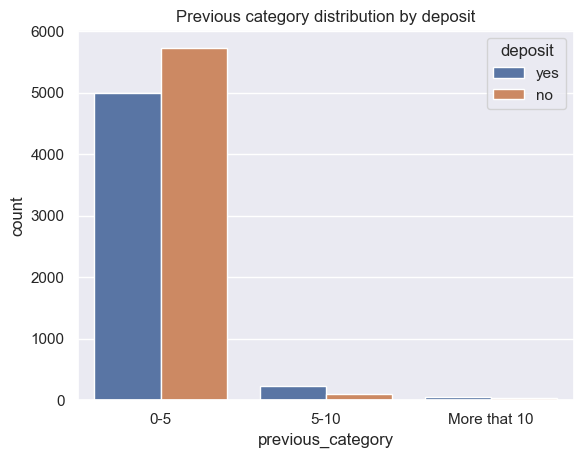

In [199]:
previous_category_dict = dict({
    0 : '0-5',
    1 : '5-10',
    2 : 'More that 10'
})

def previous_category_funk(number):
    if number <= 5: return 0
    elif number <= 10: return 1
    else: return 2

bank_df['previous_category'] = bank_df['previous'].apply(previous_category_funk)
drop_cols.append('previous')

sns.countplot(x=bank_df['previous_category'].apply(lambda x: previous_category_dict[x]), hue=bank_df['deposit'])
plt.title('Previous category distribution by deposit')
plt.show()

### Преобразуем оставшиеся признаки для машинного обучения

In [200]:
# создадим экземпляр кодировщика
le = preprocessing.LabelEncoder()

# закодируем признаки
bank_df['education_encoded'] = le.fit_transform(bank_df['education'])
bank_df['deposit_encoded'] = le.fit_transform(bank_df['deposit'])
bank_df['default_encoded'] = le.fit_transform(bank_df['default'])
bank_df['housing_encoded'] = le.fit_transform(bank_df['housing'])
bank_df['loan_encoded'] = le.fit_transform(bank_df['loan'])

drop_cols.extend(['education', 'deposit', 'default', 'housing', 'loan'])

# создадим дамми-переменные
pd.get_dummies(bank_df[['job', 'marital', 'contact', 'month', 'poutcome']])
bank_df = pd.concat([bank_df, pd.get_dummies(bank_df[['job', 'marital', 'contact', 'month', 'poutcome']])], axis=1)

drop_cols.extend(['job', 'marital', 'contact', 'month', 'poutcome'])

# удалим ненужные столбцы из набора данных
bank_df = bank_df.drop(drop_cols, axis=1)

### Построим и исследуем корреляционную матрицу

Размер матрицы корреляции: (44, 44)


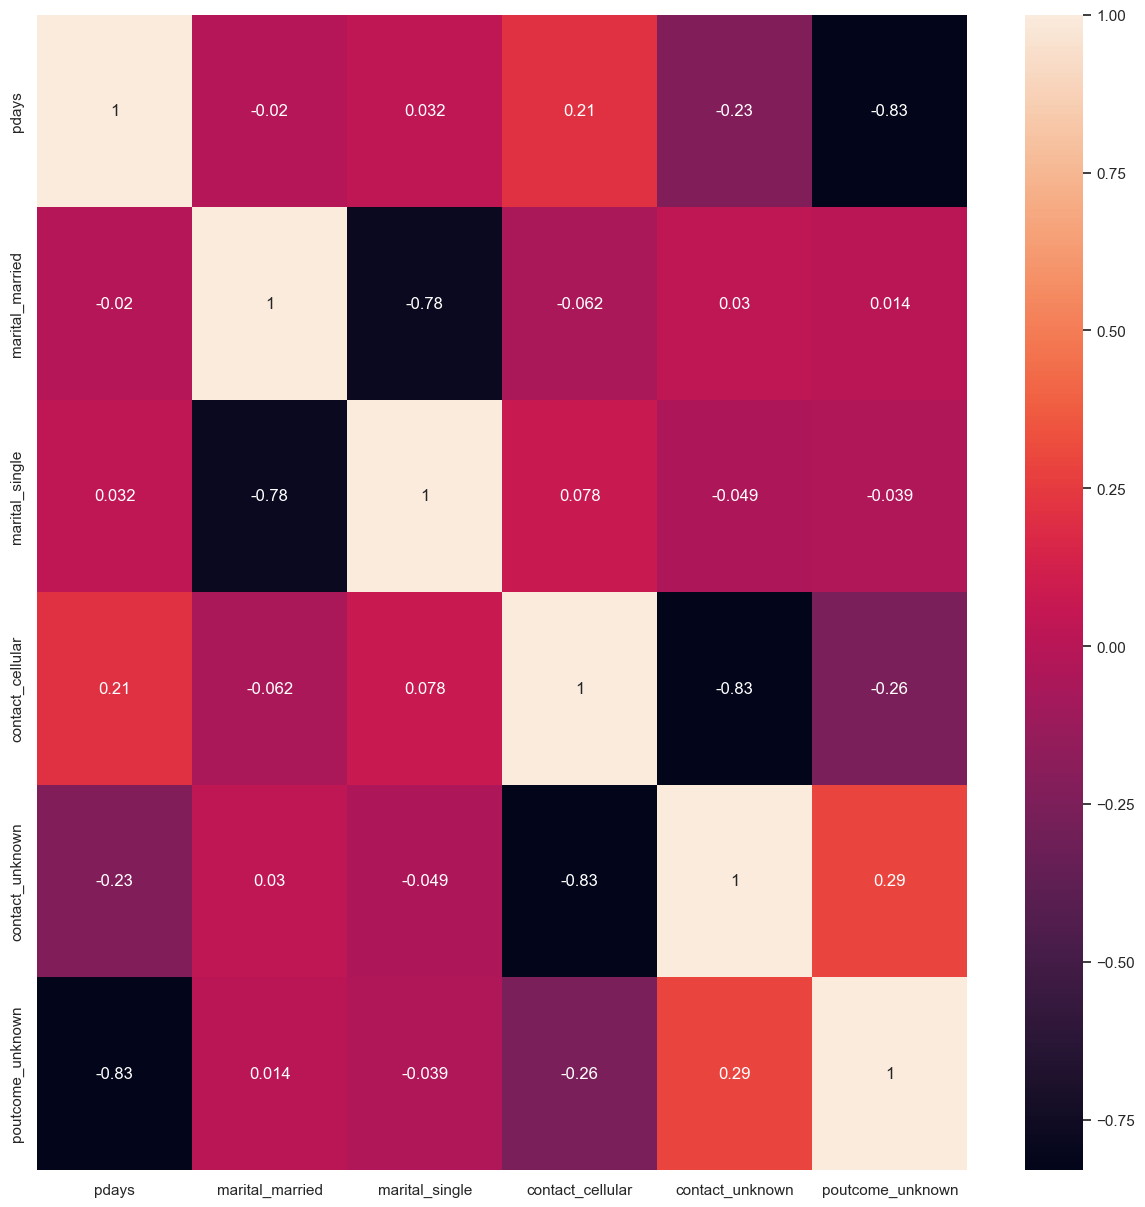

In [201]:
# построим корреляционную матрицу
corr_matrix = bank_df.drop('deposit_encoded', axis=1).corr()
print(f'Размер матрицы корреляции: {corr_matrix.shape}')

# выберем только те строки, что интересны нам на предмет мультиколлинеарности
mask = corr_matrix == 1
reduced_rows = list()
for row in corr_matrix:
    if corr_matrix[~mask][row].max() >= 0.7 or corr_matrix[~mask][row].min() <= -0.7:
        reduced_rows.append(row)

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix.loc[reduced_rows, reduced_rows], annot=True)
plt.show()

In [202]:
# вычислим определитель матрицы и ее ранг
mtrx_det = np.linalg.det(bank_df.drop('deposit_encoded', axis=1).corr().values)
mtrx_rank = np.linalg.matrix_rank(bank_df.drop('deposit_encoded', axis=1).corr().values)
print(f'Определитель матрицы: {mtrx_det:.4f}. Ранг матрицы: {mtrx_rank}.')

Определитель матрицы: 0.0000. Ранг матрицы: 39.


Определитель матрицы равен 0. Попробуем избавиться от мультиколлинеарности. Для этого удалим три признака, коэффициент корреляции, которых близок к 0,8. Удалим те из них, что меньше коррелируют с целевой переменной.

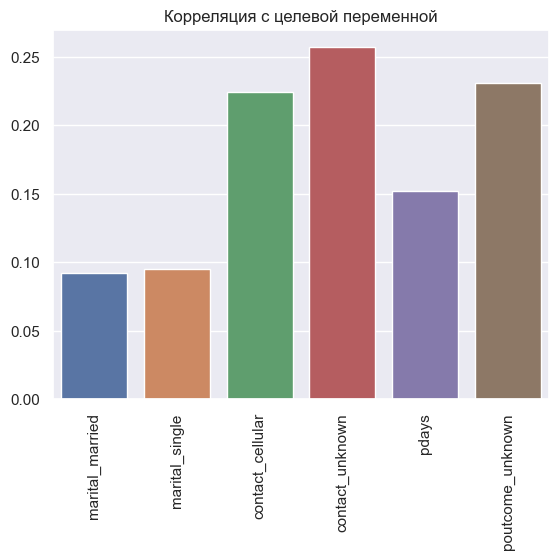

Определитель матрицы: 0.0000. Ранг матрицы: 38.


In [203]:
for_plot = bank_df.corr()['deposit_encoded'][
    ['marital_married',
     'marital_single',
     'contact_cellular',
     'contact_unknown',
     'pdays',
     'poutcome_unknown']
]
plt.xticks(rotation=90)
sns.barplot(x=for_plot.index, y=for_plot.abs().values)
plt.title('Корреляция с целевой переменной')
plt.show()

bank_df = bank_df.drop(['marital_married', 'contact_cellular', 'pdays'], axis=1)

mtrx_det = np.linalg.det(bank_df.drop('deposit_encoded', axis=1).corr().values)
mtrx_rank = np.linalg.matrix_rank(bank_df.drop('deposit_encoded', axis=1).corr().values)
print(f'Определитель матрицы: {mtrx_det:.4f}. Ранг матрицы: {mtrx_rank}.')

Попробуем объединить в один несколько признаков, которые плохо коррелируют с целевой переменной с помощью PCA.

In [204]:
# создаем список признаков с коэффициентом корреляции меньше 0.05
mask = bank_df.corr()['deposit_encoded'].abs() < 0.05
pca_columns = bank_df.columns[mask].to_list()

# объединяем такие признаки в один с помощью PCA
pca = PCA(n_components=1, random_state=42)
bank_df['pca_column'] = pca.fit_transform(bank_df[pca_columns])
bank_df = bank_df.drop(pca_columns, axis=1)

mtrx_det = np.linalg.det(bank_df.drop('deposit_encoded', axis=1).corr().values)
mtrx_rank = np.linalg.matrix_rank(bank_df.drop('deposit_encoded', axis=1).corr().values)
print(f'Определитель матрицы: {mtrx_det:.4f}. Ранг матрицы: {mtrx_rank}.')

Определитель матрицы: 0.0786. Ранг матрицы: 23.


Определитель матрицы корреляции теперь отличен от нуля (с высокой вероятностью). Давайте посмотрим, насколько сильно признаки коррелируют с целевой переменной.

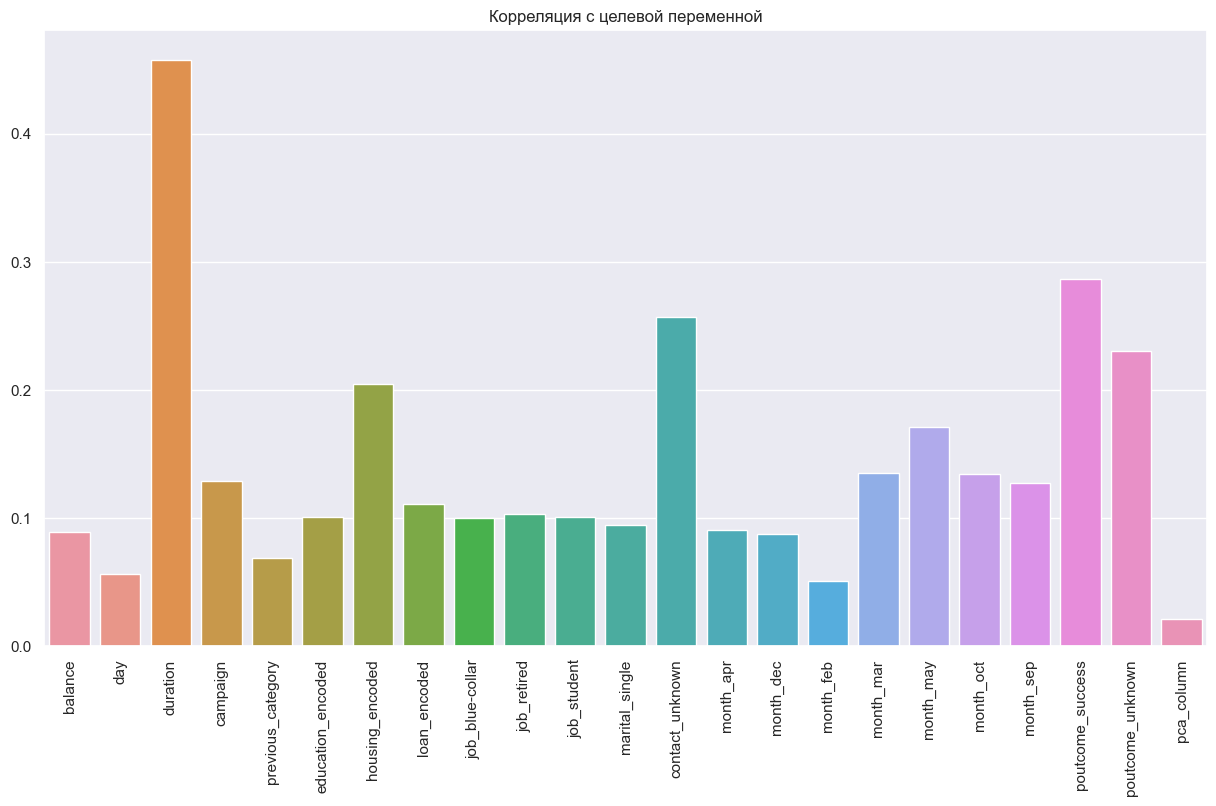

In [205]:
plt.figure(figsize=(15, 8))
plt.xticks(rotation=90)
corr_plot = bank_df.corr()['deposit_encoded']
sns.barplot(x=corr_plot.drop('deposit_encoded').index, y=corr_plot.drop('deposit_encoded').abs().values)
plt.title('Корреляция с целевой переменной')
plt.show()

### Разобьем набор данных на обучающие и тестовые выборки и нормализуем их

In [206]:
X = bank_df.drop(['deposit_encoded'], axis=1)
y = bank_df['deposit_encoded']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Логистическая регрессия

In [207]:
# обучим модель
log_reg = linear_model.LogisticRegression(
    solver='sag',
    max_iter=1000,
    random_state=42
)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

print('Метрики логистической регрессии на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики логистической регрессии на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

# создадим таблицу, в которую будем добавлять результаты
final_table = pd.DataFrame(index=['Accuracy(train)', 'Accuracy(test)'])
final_table['LogisticRegression'] = [
    metrics.accuracy_score(y_train, y_train_pred),
    metrics.accuracy_score(y_test, y_test_pred)
]

Метрики логистической регрессии на обучающей выборке:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3926
           1       0.83      0.78      0.80      3535

    accuracy                           0.82      7461
   macro avg       0.82      0.82      0.82      7461
weighted avg       0.82      0.82      0.82      7461

Метрики логистической регрессии на тестовой выборке:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1935
           1       0.83      0.76      0.80      1741

    accuracy                           0.81      3676
   macro avg       0.82      0.81      0.81      3676
weighted avg       0.82      0.81      0.81      3676



### Решающие деревья

Сначала обучим решающее деревья, не ограничивая максимальную глубину.

In [208]:
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42 #генератор случайных чисел
)
dt_clf.fit(X_train, y_train)
current_depth = dt_clf.get_depth()
y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)

print('Метрики решающего дерева на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики решающего дерева на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

Метрики решающего дерева на обучающей выборке:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3926
           1       1.00      1.00      1.00      3535

    accuracy                           1.00      7461
   macro avg       1.00      1.00      1.00      7461
weighted avg       1.00      1.00      1.00      7461

Метрики решающего дерева на тестовой выборке:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1935
           1       0.77      0.74      0.75      1741

    accuracy                           0.77      3676
   macro avg       0.77      0.77      0.77      3676
weighted avg       0.77      0.77      0.77      3676



Очевидно, что мы получили переобученную модель. Теперь подберем оптимальную глубину дерева.

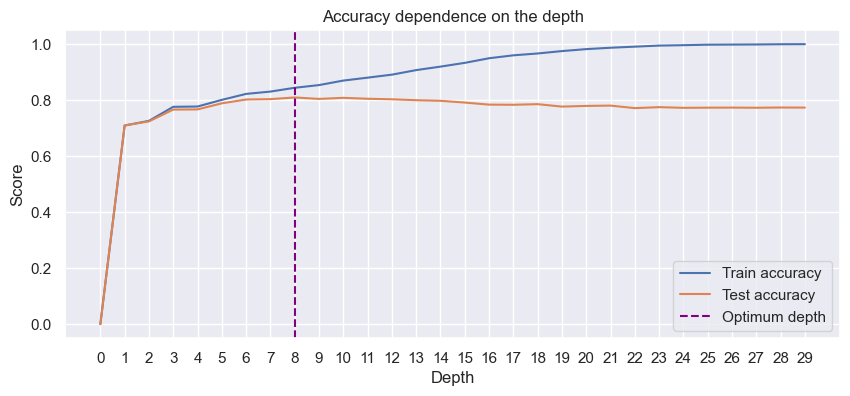

Оптимальная глубина решающего дерева: 8.


In [209]:
# будем постепенно увеличивать глубину дерева и сравнивать 
# метрику Accuracy на тренировочном и тестовом наборах
train_accuracy = [0]
test_accuracy = [0]
flag = True
for depth in range(1, current_depth):
    dt_clf = tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности,
        max_depth=depth,
        random_state=42 #генератор случайных чисел
    )
    dt_clf.fit(X_train, y_train)
    y_train_pred = dt_clf.predict(X_train)
    train_accuracy.append(metrics.accuracy_score(y_train, y_train_pred))
    y_test_pred = dt_clf.predict(X_test)    
    test_accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
    if (test_accuracy[-1] < test_accuracy[-2]) and flag:
        optimum_depth = depth - 1
        flag = False

# визуализируем метрики при различной глубине
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(train_accuracy, label='Train accuracy')
#Строим линейный график зависимости precision от threshold
ax.plot(test_accuracy, label='Test accuracy')

plt.axvline(optimum_depth, label='Optimum depth', ls='--', c='purple')
 
#Даём графику название и подписываем оси
ax.set_title('Accuracy dependence on the depth')
ax.set_xlabel('Depth')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(range(current_depth)) 
#Отображаем легенду
ax.legend()
plt.show()

print(f'Оптимальная глубина решающего дерева: {optimum_depth}.')

Обучим решающее дерево с полученной глубиной.

In [210]:
# обучите решающие деревья, настройте максимальную глубину
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=optimum_depth,
    random_state=42 #генератор случайных чисел
)
dt_clf.fit(X_train, y_train)
y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)

print('Метрики решающего дерева на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики решающего дерева на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

# добавим результаты в итоговую таблицу
final_table['DecisionTree(manual)'] = [
    metrics.accuracy_score(y_train, y_train_pred),
    metrics.accuracy_score(y_test, y_test_pred)
]

Метрики решающего дерева на обучающей выборке:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3926
           1       0.82      0.85      0.84      3535

    accuracy                           0.84      7461
   macro avg       0.84      0.84      0.84      7461
weighted avg       0.84      0.84      0.84      7461

Метрики решающего дерева на тестовой выборке:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1935
           1       0.79      0.81      0.80      1741

    accuracy                           0.81      3676
   macro avg       0.81      0.81      0.81      3676
weighted avg       0.81      0.81      0.81      3676



### Попробуем подобрать оптимальные гиперпараметры с помощью Grid Search

In [211]:
params = {
    'min_samples_split' : [1, 2, 3, 4, 5],
    'max_depth' : [5, 6, 7, 8, 9, 10]
}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42 #генератор случайных чисел
    ), 
    param_grid=params, 
    cv=5, 
    n_jobs = -1,
    verbose=2
)

grid_search.fit(X_train, y_train)
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print(f'Оптимальные параметры: {grid_search.best_params_}')

# обучите решающие деревья, настройте максимальную глубину
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    random_state=42 #генератор случайных чисел
)
dt_clf.fit(X_train, y_train)
y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)

print('Метрики решающего дерева на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики решающего дерева на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

# добавим результаты в итоговую таблицу
final_table['DecisionTree(grid_search)'] = [
    metrics.accuracy_score(y_train, y_train_pred),
    metrics.accuracy_score(y_test, y_test_pred)
]

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Оптимальные параметры: {'max_depth': 9, 'min_samples_split': 2}
Метрики решающего дерева на обучающей выборке:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3926
           1       0.84      0.86      0.85      3535

    accuracy                           0.85      7461
   macro avg       0.85      0.85      0.85      7461
weighted avg       0.85      0.85      0.85      7461

Метрики решающего дерева на тестовой выборке:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1935
           1       0.79      0.80      0.80      1741

    accuracy                           0.80      3676
   macro avg       0.80      0.80      0.80      3676
weighted avg       0.80      0.80      0.80      3676



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Случайный лес

In [212]:
# обучим модель случайного леса
rf_clf = ensemble.RandomForestClassifier(
    criterion='gini',
    random_state=42
)

rf_clf.fit(X_train, y_train)
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print('Метрики случайного леса на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики случайного леса на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

Метрики случайного леса на обучающей выборке:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3926
           1       1.00      1.00      1.00      3535

    accuracy                           1.00      7461
   macro avg       1.00      1.00      1.00      7461
weighted avg       1.00      1.00      1.00      7461

Метрики случайного леса на тестовой выборке:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1935
           1       0.81      0.85      0.83      1741

    accuracy                           0.84      3676
   macro avg       0.84      0.84      0.84      3676
weighted avg       0.84      0.84      0.84      3676



Очевидно, что модель переобучена. Попробуем вручную определить подходящую глубину, которая позволит избежать переобучения.

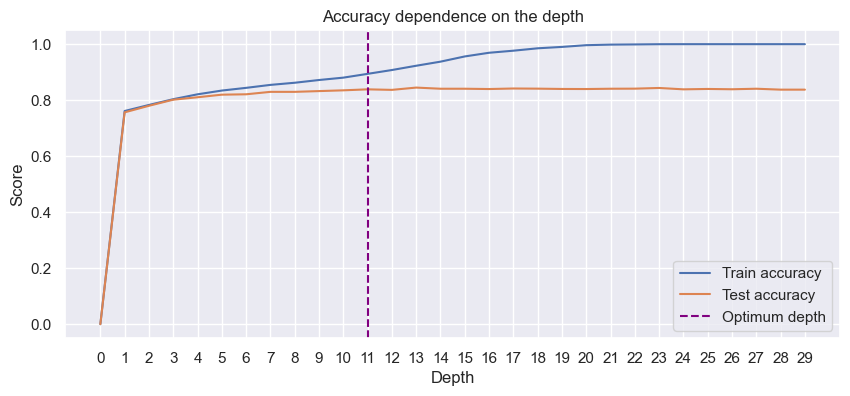

Оптимальная глубина решающего дерева для случайного леса: 11.


In [213]:
# будем постепенно увеличивать глубину деревьев и сравнивать 
# метрику Accuracy на тренировочном и тестовом наборах
train_accuracy = [0]
test_accuracy = [0]
flag = True
for depth in range(1, current_depth):
    rf_clf = ensemble.RandomForestClassifier(
        criterion='gini', #критерий информативности,
        max_depth=depth,
        random_state=42 #генератор случайных чисел
    )
    rf_clf.fit(X_train, y_train)
    y_train_pred = rf_clf.predict(X_train)
    train_accuracy.append(metrics.accuracy_score(y_train, y_train_pred))
    y_test_pred = rf_clf.predict(X_test)    
    test_accuracy.append(metrics.accuracy_score(y_test, y_test_pred))
    if (test_accuracy[-1] < test_accuracy[-2]) and flag:
        optimum_depth = depth - 1
        flag = False

# визуализируем метрики при различной глубине
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

ax.plot(train_accuracy, label='Train accuracy')

ax.plot(test_accuracy, label='Test accuracy')

plt.axvline(optimum_depth, label='Optimum depth', ls='--', c='purple')
 
#Даём графику название и подписываем оси
ax.set_title('Accuracy dependence on the depth')
ax.set_xlabel('Depth')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(range(current_depth)) 
#Отображаем легенду
ax.legend()
plt.show()

print(f'Оптимальная глубина решающего дерева для случайного леса: {optimum_depth}.')

Построим модель с найденной глубиной решающих деревьев.

In [214]:
# обучим модель случайного леса
rf_clf = ensemble.RandomForestClassifier(
    criterion='gini',
    max_depth = optimum_depth,
    random_state=42
)

rf_clf.fit(X_train, y_train)
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print('Метрики случайного леса на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики случайного леса на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

Метрики случайного леса на обучающей выборке:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      3926
           1       0.87      0.92      0.89      3535

    accuracy                           0.89      7461
   macro avg       0.89      0.90      0.89      7461
weighted avg       0.90      0.89      0.89      7461

Метрики случайного леса на тестовой выборке:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1935
           1       0.81      0.87      0.84      1741

    accuracy                           0.84      3676
   macro avg       0.84      0.84      0.84      3676
weighted avg       0.84      0.84      0.84      3676



Попробуем оптимизировать модель, подобрав гиперпараметры с помощью Optuna.

In [215]:
# выполним оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 2, optimum_depth, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        criterion='gini',
                                        random_state=42)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1).mean()

    return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("Accuracy на обучающем наборе для логистической регресии (Optuna): {:.2f}".format(study_rf.best_value))

[I 2023-06-10 10:50:10,305] A new study created in memory with name: RandomForestClassifier
[I 2023-06-10 10:50:11,163] Trial 0 finished with value: 0.8146347835924216 and parameters: {'n_estimators': 180, 'max_depth': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8146347835924216.
[I 2023-06-10 10:50:11,849] Trial 1 finished with value: 0.8242850011402633 and parameters: {'n_estimators': 139, 'max_depth': 5, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8242850011402633.
[I 2023-06-10 10:50:12,635] Trial 2 finished with value: 0.8309862468104058 and parameters: {'n_estimators': 147, 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8309862468104058.
[I 2023-06-10 10:50:13,496] Trial 3 finished with value: 0.8371524666495478 and parameters: {'n_estimators': 136, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8371524666495478.
[I 2023-06-10 10:50:14,634] Trial 4 finished with value: 0.8376877618340458 and parameters: {'n_es

Наилучшие значения гиперпараметров {'n_estimators': 196, 'max_depth': 10, 'min_samples_leaf': 8}
Accuracy на обучающем наборе для логистической регресии (Optuna): 0.84


Обучим модель с найденными гиперпараметрами.

In [216]:
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=study_rf.best_params['n_estimators'], #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf = study_rf.best_params['min_samples_leaf'],
    max_depth=study_rf.best_params['max_depth'], #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)

rf_clf.fit(X_train, y_train)
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print('Метрики случайного леса на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики случайного леса на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

# добавим результаты в итоговую таблицу
final_table['RandomForest(optuna)'] = [
    metrics.accuracy_score(y_train, y_train_pred),
    metrics.accuracy_score(y_test, y_test_pred)
]

Метрики случайного леса на обучающей выборке:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      3926
           1       0.83      0.88      0.86      3535

    accuracy                           0.86      7461
   macro avg       0.86      0.86      0.86      7461
weighted avg       0.86      0.86      0.86      7461

Метрики случайного леса на тестовой выборке:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1935
           1       0.80      0.86      0.83      1741

    accuracy                           0.83      3676
   macro avg       0.83      0.83      0.83      3676
weighted avg       0.83      0.83      0.83      3676



### Градиентный бустинг

In [217]:
# обучим модель градиентного бустинга
gb_clf = ensemble.GradientBoostingClassifier(
    random_state=42 #генератор случайных чисел
)

gb_clf.fit(X_train, y_train)
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)

print('Метрики градиентного бустинга на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики градиентного бустинга на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

Метрики градиентного бустинга на обучающей выборке:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      3926
           1       0.84      0.87      0.85      3535

    accuracy                           0.86      7461
   macro avg       0.86      0.86      0.86      7461
weighted avg       0.86      0.86      0.86      7461

Метрики градиентного бустинга на тестовой выборке:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1935
           1       0.81      0.83      0.82      1741

    accuracy                           0.83      3676
   macro avg       0.83      0.83      0.83      3676
weighted avg       0.83      0.83      0.83      3676



Переобучения нет. Попробуем оптимизировать модель, выполнив поиск гиперпараметров с помощью Optuna.

In [218]:
def optuna_rf(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.1, 0.6, step=0.1)
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 2, 20, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.GradientBoostingClassifier(learning_rate = learning_rate,
                                        n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        random_state=42)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1).mean()

    return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="GradientBoostingClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("Accuracy на обучающем наборе для логистической регресии (Optuna): {:.2f}".format(study.best_value))

[I 2023-06-10 10:50:29,248] A new study created in memory with name: GradientBoostingClassifier
[I 2023-06-10 10:50:31,307] Trial 0 finished with value: 0.8480096572207387 and parameters: {'learning_rate': 0.2, 'n_estimators': 121, 'max_depth': 6, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8480096572207387.
[I 2023-06-10 10:50:38,412] Trial 1 finished with value: 0.8466689950780137 and parameters: {'learning_rate': 0.2, 'n_estimators': 159, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8480096572207387.
[I 2023-06-10 10:50:45,083] Trial 2 finished with value: 0.8447914216298041 and parameters: {'learning_rate': 0.30000000000000004, 'n_estimators': 197, 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8480096572207387.
[I 2023-06-10 10:50:49,542] Trial 3 finished with value: 0.842245671938214 and parameters: {'learning_rate': 0.5, 'n_estimators': 182, 'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8480096

Наилучшие значения гиперпараметров {'learning_rate': 0.4, 'n_estimators': 132, 'max_depth': 3, 'min_samples_leaf': 7}
Accuracy на обучающем наборе для логистической регресии (Optuna): 0.85


Обучим модель с найденными гиперпараметрами.

In [219]:
gb_clf = ensemble.GradientBoostingClassifier(
    learning_rate=study.best_params['learning_rate'],
    n_estimators=study.best_params['n_estimators'], #число деревьев
    min_samples_leaf = study.best_params['min_samples_leaf'],
    max_depth=study.best_params['max_depth'], #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)

gb_clf.fit(X_train, y_train)
y_train_pred = gb_clf.predict(X_train)
y_test_pred = gb_clf.predict(X_test)

print('Метрики градиентного бустинга на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики градиентного бустинга на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

# добавим результаты в итоговую таблицу
final_table['GradientBoosting(optuna)'] = [
    metrics.accuracy_score(y_train, y_train_pred),
    metrics.accuracy_score(y_test, y_test_pred)
]

Метрики градиентного бустинга на обучающей выборке:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      3926
           1       0.88      0.91      0.90      3535

    accuracy                           0.90      7461
   macro avg       0.90      0.90      0.90      7461
weighted avg       0.90      0.90      0.90      7461

Метрики градиентного бустинга на тестовой выборке:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1935
           1       0.82      0.84      0.83      1741

    accuracy                           0.84      3676
   macro avg       0.84      0.84      0.84      3676
weighted avg       0.84      0.84      0.84      3676



### Стекинг

Релизуем стекинг, где базовыми моделями будут случайный лес и градиентный бустинг, а метамоделью — логистическая регрессия.

In [220]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('rf', ensemble.RandomForestClassifier(
        criterion='gini', #критерий эффективности
        max_depth=11,
        random_state=42 #генератор случайных чисел
    )),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate = 0.2,
        random_state=42 #генератор случайных чисел
    ))
]

st_clf = ensemble.StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression( #метамодель
        solver='saga',
        max_iter=1000,
        random_state=42
    )
)

st_clf.fit(X_train, y_train)
y_train_pred = st_clf.predict(X_train)
y_test_pred = st_clf.predict(X_test)

print('Метрики стекинга на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики стекинга на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

Метрики стекинга на обучающей выборке:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      3926
           1       0.86      0.90      0.88      3535

    accuracy                           0.88      7461
   macro avg       0.88      0.88      0.88      7461
weighted avg       0.88      0.88      0.88      7461

Метрики стекинга на тестовой выборке:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1935
           1       0.82      0.84      0.83      1741

    accuracy                           0.84      3676
   macro avg       0.84      0.84      0.84      3676
weighted avg       0.84      0.84      0.84      3676



Переобучения нет. Попробуем оптимизировать модель, выполнив поиск гиперпараметров с помощью Optuna.

In [221]:
def optuna_rf(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.1, 0.6, step=0.1)
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 2, 11, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    # создаем модель
    estimators = [
        ('rf', ensemble.RandomForestClassifier(
            n_estimators = n_estimators,
            max_depth = max_depth,
            criterion='gini', #критерий эффективности
            random_state=42 #генератор случайных чисел
        )),
        ('gb', ensemble.GradientBoostingClassifier(
            learning_rate = learning_rate,
            min_samples_leaf = min_samples_leaf,
            random_state=42 #генератор случайных чисел
        ))
    ]
    model = ensemble.StackingClassifier(
        estimators=estimators, #базовые модели в стекинге
        final_estimator=linear_model.LogisticRegression(
            solver='saga',
            penalty=penalty,
            max_iter=1000,
            random_state=42
        )
    )
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1).mean()

    return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="StackingClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("Accuracy на обучающем наборе для логистической регресии (Optuna): {:.2f}".format(study.best_value))

[I 2023-06-10 10:51:47,936] A new study created in memory with name: StackingClassifier
[I 2023-06-10 10:51:56,011] Trial 0 finished with value: 0.8461313654965352 and parameters: {'learning_rate': 0.2, 'n_estimators': 150, 'max_depth': 8, 'min_samples_leaf': 2, 'penalty': 'l2'}. Best is trial 0 with value: 0.8461313654965352.
[I 2023-06-10 10:52:02,738] Trial 1 finished with value: 0.8469368222392614 and parameters: {'learning_rate': 0.6, 'n_estimators': 165, 'max_depth': 2, 'min_samples_leaf': 4, 'penalty': 'l1'}. Best is trial 1 with value: 0.8469368222392614.
[I 2023-06-10 10:52:10,599] Trial 2 finished with value: 0.8455962498810357 and parameters: {'learning_rate': 0.5, 'n_estimators': 150, 'max_depth': 6, 'min_samples_leaf': 10, 'penalty': 'l2'}. Best is trial 1 with value: 0.8469368222392614.
[I 2023-06-10 10:52:18,045] Trial 3 finished with value: 0.8518957099170571 and parameters: {'learning_rate': 0.6, 'n_estimators': 138, 'max_depth': 6, 'min_samples_leaf': 4, 'penalty': 'l

Наилучшие значения гиперпараметров {'learning_rate': 0.6, 'n_estimators': 138, 'max_depth': 6, 'min_samples_leaf': 4, 'penalty': 'l2'}
Accuracy на обучающем наборе для логистической регресии (Optuna): 0.85


Обучим модель с найденными гиперпараметрами.

In [222]:
estimators = [
    ('rf', ensemble.RandomForestClassifier(
        n_estimators = study.best_params['n_estimators'],
        max_depth = study.best_params['max_depth'],
        criterion='gini', #критерий эффективности
        random_state=42 #генератор случайных чисел
    )),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate = study.best_params['learning_rate'],
        min_samples_leaf = study.best_params['min_samples_leaf'],
        random_state=42 #генератор случайных чисел
    ))
]

st_clf = ensemble.StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression( #метамодель
        solver='saga',
        penalty=study.best_params['penalty'],
        max_iter=1000,
        random_state=42
    )
)

st_clf.fit(X_train, y_train)
y_train_pred = st_clf.predict(X_train)
y_test_pred = st_clf.predict(X_test)

print('Метрики стекинга на обучающей выборке:')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики стекинга на тестовой выборке:')
print(metrics.classification_report(y_test, y_test_pred))

# добавим результаты в итоговую таблицу
final_table['Stacking(optuna)'] = [
    metrics.accuracy_score(y_train, y_train_pred),
    metrics.accuracy_score(y_test, y_test_pred)
]

Метрики стекинга на обучающей выборке:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3926
           1       0.88      0.91      0.89      3535

    accuracy                           0.90      7461
   macro avg       0.90      0.90      0.90      7461
weighted avg       0.90      0.90      0.90      7461

Метрики стекинга на тестовой выборке:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1935
           1       0.81      0.84      0.83      1741

    accuracy                           0.84      3676
   macro avg       0.83      0.84      0.83      3676
weighted avg       0.84      0.84      0.84      3676



Выведем итоговую таблицу.

In [223]:
print('Итоговая таблица:')
display(final_table)

Итоговая таблица:


,LogisticRegression,DecisionTree(manual),DecisionTree(grid_search),RandomForest(optuna),GradientBoosting(optuna),Stacking(optuna)
Accuracy(train),0.819729,0.844123,0.853773,0.858598,0.902560,0.897735
Accuracy(test),0.814200,0.809576,0.804407,0.832971,0.836235,0.835147


Судя по результатам, лучше всего показал себя градиантный бустинг. В ходе обучения моделей мы использовали методы регуляризации, чтобы избежать переобучения, а также оптимизировали гиперпараметры. В целом мы получили схожие метрики на продвинутых для продвинутых моделей. На более простых моделях значение метрики Accuracy чуть ниже.